In [74]:
import pandas as pd
from numpy import sort
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [100]:
import hopsworks
from settings import *
project = hopsworks.login(project=SETTINGS["FS_PROJECT_NAME"], api_key_value=SETTINGS["FS_API_KEY"])
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/361623
Connected. Call `.close()` to terminate connection gracefully.


In [76]:
# The feature view is the input set of features for your model. The features can come from different feature groups.
# You can select features from different feature groups and join them together to create a feature view
weather_fg = fs.get_feature_group(name="weather", version=1)
lag_fg = fs.get_feature_group(name="lagged_demand", version=1)

query = lag_fg.select_all().join(weather_fg.select_all(), on=['settlement_date'])


feature_view = fs.get_or_create_feature_view(name="lag_demand_and_weather",
                                  version=1,
                                  labels=["england_wales_demand"],
                                  query=query)

In [77]:
query = weather_fg.select_all()

feature_view = fs.get_or_create_feature_view(name="weather",
                                  version=1,
                                  description="Read from weather dataset",
                                  labels=["england_wales_demand"],
                                  query=query)

In [78]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X1, X2, y1, y2 = feature_view.train_test_split(train_start="2009-01-01", train_end="2020-12-01", test_start="2020-12-02", test_end="2023-12-07")

Finished: Reading data from Hopsworks, using Hive (4.41s) 


In [82]:
def sort_data(Xt, yt):
    X = Xt.copy()
    y = yt.copy()
    y = y.set_index(X['settlement_date']).sort_index()
    X.set_index(['settlement_date'], inplace=True)
    X.sort_index(inplace=True)
    return X, y

def add_date_features(Xt, yt):
    X = Xt.copy()
    y = yt.copy()
    X["day_of_week"] = X['settlement_date'].dt.dayofweek
    X["day_of_year"] = X['settlement_date'].dt.dayofyear
    X["month"] = X['settlement_date'].dt.month
    X["quarter"] = X['settlement_date'].dt.quarter
    X["year"] = X['settlement_date'].dt.year
    return X, y

def preprocessing(Xt, yt, Xt2, yt2):

    Xt, yt = add_date_features(Xt, yt)
    Xt2, yt2 = add_date_features(Xt2, yt2)

    Xt, yt = sort_data(Xt, yt)
    Xt2, yt2 = sort_data(Xt2, yt2)

    X = pd.concat([Xt, Xt2], axis=0)
    y = pd.concat([yt, yt2], axis=0)
    temps = y['england_wales_demand']

    # add lagged features
    lagged_demand = pd.concat([temps.shift(7), temps.shift(14), temps.shift(21), temps.shift(28)], axis=1)
    lagged_demand = lagged_demand.set_axis(['england_wales_demand_lag7',
                                            'england_wales_demand_lag14', 'england_wales_demand_lag21',
                                           'england_wales_demand_lag28'], axis=1)
    df = pd.concat([lagged_demand, X, y], axis=1)
    df.dropna(inplace=True)
    #df = pd.concat([X, y], axis=1)

    train = df.loc[:'2020-12-01 00:00:00']
    test = df.loc['2020-12-02 00:00:00':]
    y_train = train['england_wales_demand']
    X_train = train.drop(['england_wales_demand'], axis=1)
    y_test = test['england_wales_demand']
    X_test = test.drop(['england_wales_demand'], axis=1)
    return X_train, y_train, X_test, y_test


In [83]:
X_train, y_train, X_test, y_test = preprocessing(X1, y1, X2, y2)

In [85]:
import lightgbm
import xgboost
import sklearn
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
print(lightgbm.__version__)
print(xgboost.__version__)
print(sklearn.__version__)

4.2.0
2.0.2
1.3.0


In [86]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(random_state=42)

#parameters = {
#    "max_depth": [3, 4, 6, 5, 10],
#    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
#    "n_estimators": [100, 300, 500, 700],
#    "colsample_bytree": [0.3, 0.5, 0.7]
#}

parameters = {'max_depth': [3], 'learning_rate': [0.05], 'n_estimators': [700], 'colsample_bytree': [0.3]}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.3], 'learning_rate': [0.05],
                         'max_depth': [3], 'n_estimators': [700]},
             scoring='neg_mean_squared_error')

In [87]:
import matplotlib.pyplot as plt
xgboost_model = grid_search.best_estimator_
feature_importance = xgboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()
plt.savefig('feature_importance.png')

![feature_importance.png](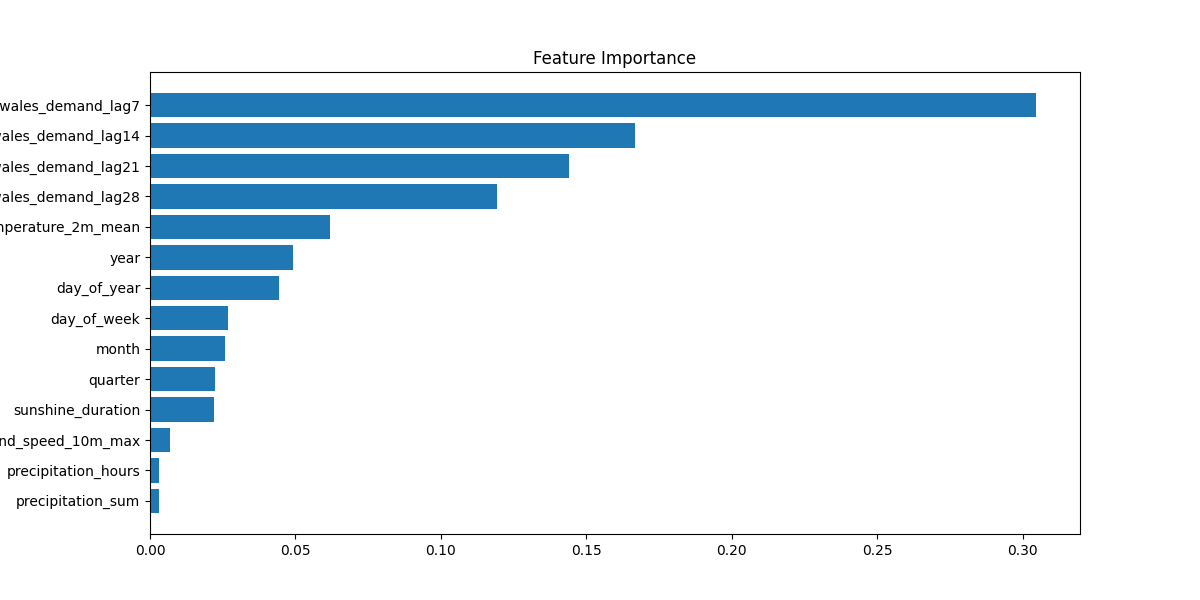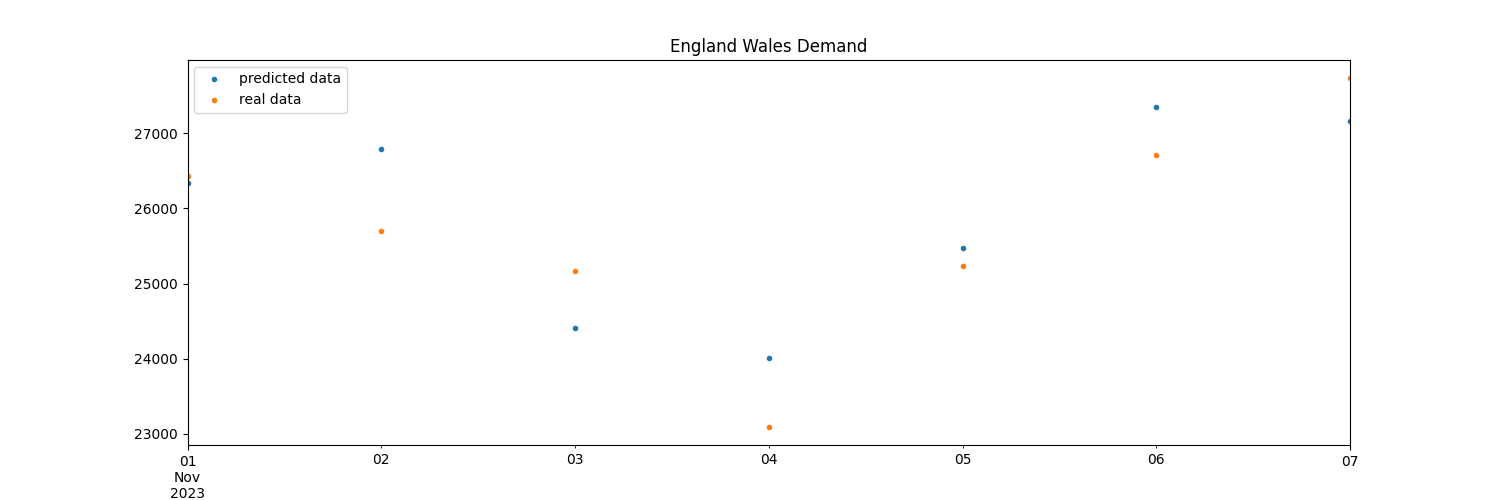)

#Score

In [88]:
grid_search.cv_results_

{'mean_fit_time': array([0.69912806]),
 'std_fit_time': array([0.24664991]),
 'mean_score_time': array([0.01032786]),
 'std_score_time': array([0.00092557]),
 'param_colsample_bytree': masked_array(data=[0.3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.05],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[700],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'colsample_bytree': 0.3,
   'learning_rate': 0.05,
   'max_depth': 3,
   'n_estimators': 700}],
 'split0_test_score': array([-1208023.17937398]),
 'split1_test_score': array([-1010696.71684313]),
 'split2_test_score': array([-1330073.88886858]),
 'split3_test_score': array([-1127851.52825994]),
 'split4_test_score'

#Best Model

In [89]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42, colsample_bytree=0.3, max_depth=3, n_estimators=700, learning_rate=0.05)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [90]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

y_pred_df = pd.DataFrame(data=y_pred, index=X_test.index)
y_pred_plot = y_pred_df.set_axis(['england_wales_demand'], axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
y_pred_plot["england_wales_demand"].plot(
    style=".", ax=ax, title="England Wales Demand", label="predicted data"
)

y_test.plot(style=".", ax=ax, label="real data")
plt.legend()

plt.savefig("test_plot.png")

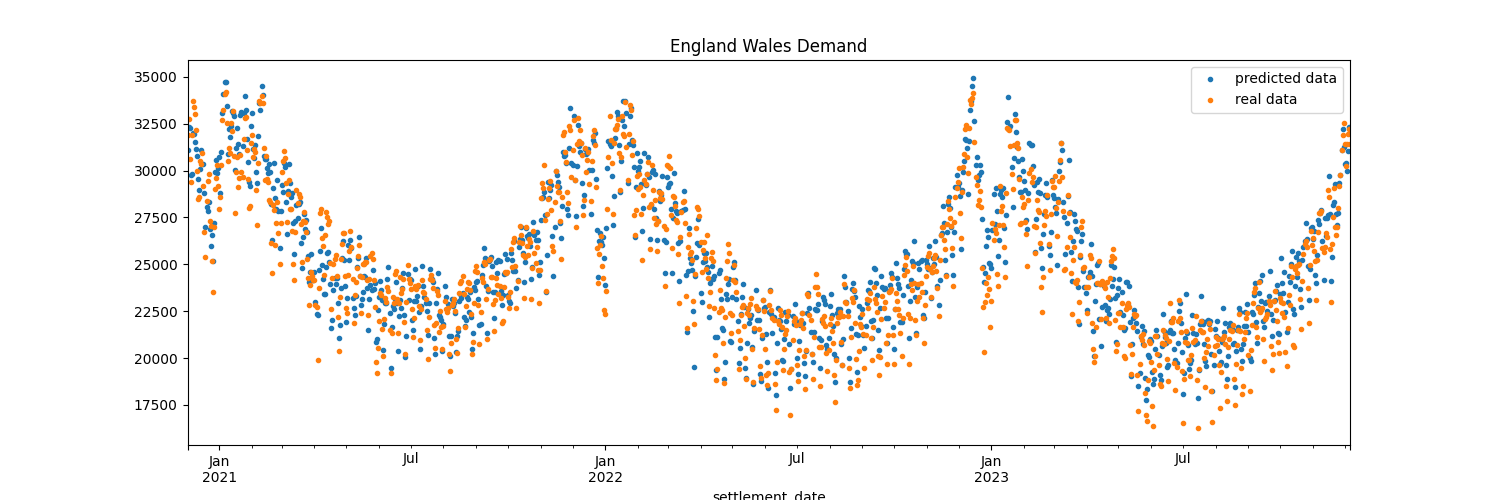


In [93]:
fig2, ax2 = plt.subplots(figsize=(15, 5))
y_pred_plot["england_wales_demand"].loc['2023-11-01 00:00:00':'2023-11-07 00:00:00'].plot(
    style=".", ax=ax2, title="England Wales Demand", label="predicted data"
)

y_test.loc['2023-11-01 00:00:00':'2023-11-07 00:00:00'].plot(style=".", ax=ax2, label="real data")
plt.legend()

#plt.savefig("1_week_plot.png")

In [94]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

1179921.0518367004

# Upload model to registry.

In [101]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'weather' directory will be saved to the model registry. Create the dir, first.
model_dir="demand"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the plot to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/demand_model.pkl")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
demand_model = mr.python.create_model(
    name="demand_model",
    model_schema=model_schema,
    description="Demand Forecast"
)

# Upload the model to the model registry, including all files in 'model_dir'
demand_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/821868 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1368 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/361623/models/demand_model/1


Model(name: 'demand_model', version: 1)